In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import re, string

from keras import optimizers
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.callbacks import EarlyStopping

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from collections import defaultdict
import sys

Using TensorFlow backend.


In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
def clean_text(cmnt_text, clean_wiki_tokens = True):
    cmnt_text = cmnt_text.lower()
    #removing links
    cmnt_text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", cmnt_text)
    #removing IP addresses
    cmnt_text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", cmnt_text)
    
    if clean_wiki_tokens:
        #removing images
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", cmnt_text)
        cmnt_text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", cmnt_text)
        
        #removing CSS
        cmnt_text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",cmnt_text)
        cmnt_text = re.sub(r"\{\|[^\}]*\|\}", " ", cmnt_text)
        
        #removing templates
        cmnt_text = re.sub(r"\[?\[user:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[wikipedia:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[special:.*\]", " ", cmnt_text)
        cmnt_text = re.sub(r"\[?\[category:.*\]", " ", cmnt_text)
        
    cmnt_text = re.sub(r"what's", "what is ", cmnt_text)
    cmnt_text = re.sub(r"\'s", " ", cmnt_text)
    cmnt_text = re.sub(r"\'ve", " have ", cmnt_text)
    cmnt_text = re.sub(r"can't", "cannot ", cmnt_text)
    cmnt_text = re.sub(r"n't", " not ", cmnt_text)
    cmnt_text = re.sub(r"i'm", "i am ", cmnt_text)
    cmnt_text = re.sub(r"\'re", " are ", cmnt_text)
    cmnt_text = re.sub(r"\'d", " would ", cmnt_text)
    cmnt_text = re.sub(r"\'ll", " will ", cmnt_text)
    cmnt_text = re.sub(r",", " ", cmnt_text)
    cmnt_text = re.sub(r"\.", " ", cmnt_text)
    cmnt_text = re.sub(r"!", " ! ", cmnt_text)
    cmnt_text = re.sub(r"\/", " ", cmnt_text)
    cmnt_text = re.sub(r"\?", " ? ", cmnt_text)
    cmnt_text = re.sub(r"\!", " ! ", cmnt_text)
    cmnt_text = re.sub(r"\"", " ", cmnt_text)
    cmnt_text = re.sub(r"\^", " ^ ", cmnt_text)
    cmnt_text = re.sub(r"\+", " + ", cmnt_text)
    cmnt_text = re.sub(r"\-", " - ", cmnt_text)
    cmnt_text = re.sub(r"\=", " = ", cmnt_text)
    cmnt_text = re.sub(r"'", " ", cmnt_text)
    cmnt_text = re.sub(r"(\d+)(k)", r"\g<1>000", cmnt_text)
    cmnt_text = re.sub(r":", " : ", cmnt_text)
    cmnt_text = re.sub(r" e g ", " eg ", cmnt_text)
    cmnt_text = re.sub(r" b g ", " bg ", cmnt_text)
    cmnt_text = re.sub(r" u s ", " american ", cmnt_text)
    cmnt_text = re.sub(r"\0s", "0", cmnt_text)
    cmnt_text = re.sub(r" 9 11 ", "911", cmnt_text)
    cmnt_text = re.sub(r"e - mail", "email", cmnt_text)
    cmnt_text = re.sub(r"j k", "jk", cmnt_text)
    cmnt_text = re.sub(r"\s{2,}", " ", cmnt_text)
    cmnt_text = re.sub(r"\n", " ", cmnt_text)
    
        
    return(cmnt_text)

In [5]:
data['clean_cmnts'] = data['comment_text'].apply(clean_text)

In [6]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_cmnts
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww ! he matches this background colour i am...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i cannot make any real suggestions on im...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [7]:
data = data.drop(['comment_text'], axis=1)
data.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_cmnts
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,0,0,0,0,0,0,d aww ! he matches this background colour i am...
2,000113f07ec002fd,0,0,0,0,0,0,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,0,0,0,0,0,0,more i cannot make any real suggestions on im...
4,0001d958c54c6e35,0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [8]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
num_class = len(label_cols)
X = data[['clean_cmnts']]
y = data[label_cols]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [10]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s):
    return re_tok.sub(r'\1', s).split()

vec = TfidfVectorizer(stop_words={'english'}, min_df=3, 
                      max_df=0.9, max_features=500,
                      strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1,)

In [11]:
vec.fit(X['clean_cmnts'])
trn_vec = vec.transform(X_train['clean_cmnts'])
tst_vec = vec.transform(X_test['clean_cmnts'])

In [12]:
trn_vec.shape, tst_vec.shape

((111699, 500), (47872, 500))

In [13]:
weight_decay = 1e-4
batch_size = 32
num_epochs = 8
num_filters = 64
embed_dim = 300

In [15]:
model = Sequential()
model.add(Dense(1000, input_dim = 500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_class, activation='sigmoid'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               250250    
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                8032      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 759,480
Trainable params: 759,480
Non-trainable params: 0
_________________________________________________________________


In [16]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss')
callbacks_list = [early_stopping]

In [17]:
hist = model.fit(trn_vec, y_train, batch_size=batch_size, epochs=num_epochs, 
                 callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 100529 samples, validate on 11170 samples
Epoch 1/8
100529/100529 [==============================] - 71s 708us/step - loss: 0.0844 - acc: 0.9728 - val_loss: 0.0781 - val_acc: 0.9744
Epoch 2/8
100529/100529 [==============================] - 69s 688us/step - loss: 0.0746 - acc: 0.9762 - val_loss: 0.0772 - val_acc: 0.9750
Epoch 3/8
100529/100529 [==============================] - 69s 687us/step - loss: 0.0700 - acc: 0.9771 - val_loss: 0.0774 - val_acc: 0.9752


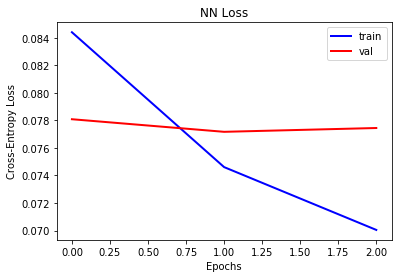

In [19]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('NN Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.savefig('NN_Loss.png', bbox_inches='tight')
plt.show()

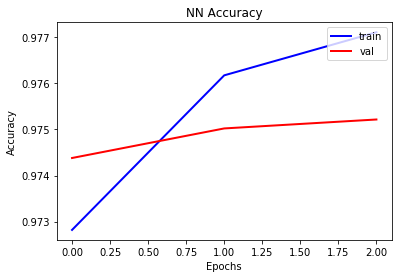

In [20]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('NN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.savefig('NN_Accuracy.png', bbox_inches='tight')
plt.show()

In [21]:
# Creating empty prediction array
col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

# Predict on train, val and test datasets
pred_train = model.predict(trn_vec)
pred_test = model.predict(tst_vec)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [22]:
# Emply array to collect AUC scores
AUC = np.zeros((2,6))
AUC

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [25]:
from sklearn import metrics
for i,x in enumerate(col):
    auc = np.array([metrics.roc_auc_score(y_train[x], pred_train[:,i]),
                    metrics.roc_auc_score(y_test[x], pred_test[:,i])])
    print(x,"Train AUC:",auc[0],", Test AUC:",auc[1])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Test AUC:",avg_auc[1])

toxic Train AUC: 0.9411173346219933 , Test AUC: 0.9193951716212738
severe_toxic Train AUC: 0.9843275648091625 , Test AUC: 0.9705675253703973
obscene Train AUC: 0.9635833663779936 , Test AUC: 0.9414328935628661
threat Train AUC: 0.9835031128743669 , Test AUC: 0.9581521129693709
insult Train AUC: 0.9574420609487033 , Test AUC: 0.937801990370102
identity_hate Train AUC: 0.9619410470730607 , Test AUC: 0.937142262546062
Average Train AUC: 0.9653190811175466 , Average Test AUC: 0.944081992740012


In [27]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score

for i, j in enumerate(col):
    print(j)
    print(confusion_matrix(y_test[j], pred_test[:, i].round()))
    print("f1_score: ",f1_score(y_test[j], pred_test[:, i].round()))
    print("Accuracy: ",accuracy_score(y_test[j], pred_test[:, i].round()))
    print("recall_score: ",recall_score(y_test[j], pred_test[:, i].round()))
    print('\n')

toxic
[[43012   278]
 [ 2534  2048]]
f1_score:  0.5929357266936884
Accuracy:  0.9412600267379679
recall_score:  0.4469663902226102


severe_toxic
[[47362    24]
 [  447    39]]
f1_score:  0.14207650273224043
Accuracy:  0.9901612633689839
recall_score:  0.08024691358024691


obscene
[[45106   210]
 [ 1120  1436]]
f1_score:  0.683484055211804
Accuracy:  0.9722175802139037
recall_score:  0.5618153364632238


threat
[[47732     4]
 [  125    11]]
f1_score:  0.1456953642384106
Accuracy:  0.997305314171123
recall_score:  0.08088235294117647


insult
[[45036   447]
 [ 1238  1151]]
f1_score:  0.5773764735390018
Accuracy:  0.9648019719251337
recall_score:  0.4817915445793219


identity_hate
[[47437     3]
 [  400    32]]
f1_score:  0.13704496788008563
Accuracy:  0.9915817179144385
recall_score:  0.07407407407407407


